In [24]:
from pysam import FastaFile
dna = FastaFile("../genome/AT_reference/GCF_000001735.4_TAIR10.1_genomic.fna")
print(dna.references)
chr_to_references = {
    "1": "CHR1",
    "2": "CHR2",
    "3": "CHR3",
    "4": "CHR4",
    "5": "CHR5",
}
a = dna.fetch(chr_to_references["1"], 0, 1000)

print(1,dna.get_reference_length(chr_to_references["1"]))
print(2,dna.get_reference_length(chr_to_references["2"]))
print(3,dna.get_reference_length(chr_to_references["3"]))
print(4,dna.get_reference_length(chr_to_references["4"]))
print(5,dna.get_reference_length(chr_to_references["5"]))


encode_dict = {
    "[mask]": 0,
    "A": 1,
    "C": 2,
    "G": 3,
    "T": 4,
    "Y": 5, # C or T
    "R": 6, # A or G
    "W": 7, # A or T
    "S": 8, # C or G
    "M": 9, # A or C
    "K": 10, # G or T
    "B": 11, # C or G or T
    "D": 12, # A or G or T
    "H": 13, # A or C or T
    "V": 14, # A or C or G
    "a": 1,
    "c": 2,
    "g": 3,
    "t": 4,
    "N": -1,
}

encode_bases = lambda bases: [encode_dict[base] for base in bases]



['CHR1', 'CHR2', 'CHR3', 'CHR4', 'CHR5', 'NC_037304.1', 'NC_000932.1']
1 30427671
2 19698289
3 23459830
4 18585056
5 26975502


In [25]:
import polars as pl
import numpy as np

def meth_rates_to_labels(dna, meth_rates: pl.DataFrame):
   

    labels_by_chrsm = {}
    for (chrsm, rates) in meth_rates.partition_by("chrsm", as_dict=True).items():
        print(chrsm, rates.height)
        sequence = pl.DataFrame({ "sequence": encode_bases(dna.fetch(chr_to_references[f"{chrsm}"]))})
        a = np.zeros(sequence.height, dtype=np.float32)
        b = np.zeros(sequence.height, dtype=np.float32)
        std_st = np.zeros(sequence.height, dtype=np.float32)
        for row in rates.iter_rows(named=True):
            
            a[row["start"] - 1 :row["end"] -1] = row["alpha"]
            b[row["start"] - 1 :row["end"] -1] = row["beta"]
            std_st[row["start"] - 1:row["end"] -1] = row["std_st"]

        labels = sequence.with_columns(pl.Series("alpha", a), pl.Series("beta", b), pl.Series("std_st", std_st))

        labels = labels.with_columns(pl.when(pl.col("sequence") == 2).then(pl.col("alpha")).otherwise(pl.lit(0.)).alias("alpha"))
        labels = labels.with_columns(pl.when(pl.col("sequence") == 2).then(pl.col("beta")).otherwise(pl.lit(0.)).alias("beta"))
        labels = labels.with_columns(pl.when(pl.col("sequence") == 2).then(pl.col("std_st")).otherwise(pl.lit(0.)).alias("std_st"))

        labels_by_chrsm[chrsm] = labels

    return labels_by_chrsm




In [26]:
meth_rates = pl.read_parquet("test.parquet").sort(["chrsm", "start", "end"])
display(meth_rates)
display(meth_rates.with_columns((pl.col("end") - pl.col("start")).alias("diff")).mean())

# labels_by_chrms = meth_rates_to_labels(dna, meth_rates)
# display(labels_by_chrms[1][100:130])



    
    





chrsm,slice,start,end,alpha,beta,std_st
i64,i64,i64,i64,f64,f64,f64
1,0,109,1264403,0.000223,0.001706,0.116518
1,0,84741,1350625,0.00021,0.002009,0.095382
1,0,155868,1436066,0.000204,0.00169,0.108577
1,0,223571,1516914,0.000361,0.000124,0.745267
1,0,306198,1598019,0.000176,0.002186,0.074999
1,0,373954,1683895,0.000193,0.001986,0.089472
1,0,457316,1767372,0.000204,0.002366,0.080282
1,0,534164,1857451,0.000265,0.002125,0.111621
1,0,607247,1945202,0.000351,0.000474,0.426224


chrsm,slice,start,end,alpha,beta,std_st,diff
f64,f64,f64,f64,f64,f64,f64,f64
2.944893,8.277002,1.2231e7,1.3597e7,0.000247,0.001544,0.222161,1.3658e6


In [27]:
chrsm_embeddings = [pl.read_parquet(f"embeddings/chr_{i}.parquet") for i in range(1, 6)]
res = pl.DataFrame()
for row in meth_rates.iter_rows():
    chrsm = row[0]
    start = row[2]
    end = row[3]
    print(chrsm, start, end)
    means = chrsm_embeddings[chrsm-1][start -1: end -1].sum()
    res = res.vstack(means)

    
    

display(res)

1 109 1264403
1 84741 1350625
1 155868 1436066
1 223571 1516914
1 306198 1598019
1 373954 1683895
1 457316 1767372
1 534164 1857451
1 607247 1945202
1 692385 2033226
1 778987 2120862
1 859381 2193093
1 940144 2258301
1 1013978 2340110
1 1097427 2418541
1 1181768 2502731
1 1264412 2585081
1 1350711 2673095
1 1436074 2767893
1 1516922 2857760
1 1598059 2943030
1 1683900 3030774
1 1767373 3121905
1 1857480 3213001
1 1945243 3297081
1 2033262 3388562
1 2120866 3472078
1 2193096 3556538
1 2258317 3654446
1 2340150 3741234
1 2418587 3822889
1 2502764 3908994
1 2585150 3990644
1 2673153 4072469
1 2768027 4157113
1 2857794 4243652
1 2943071 4328459
1 3030844 4420134
1 3121950 4503322
1 3213064 4588424
1 3297085 4691461
1 3388564 4787876
1 3472107 4869530
1 3556615 4961424
1 3654506 5049039
1 3741238 5132626
1 3822905 5210766
1 3909012 5297448
1 3990658 5381055
1 4072740 5458556
1 4157249 5537195
1 4243659 5616988
1 4328544 5708910
1 4420136 5789793
1 4503330 5884442
1 4588430 5969739
1 4691479

sequence,genes,Chromatine States,h2az,H3,H3K27Me3,H3K36Me3,H3K4Me1,H3K4Me3,H3K56Ac
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
3166165,-9407,19719564,1248718,1252514,1145402,1203266,1243083,1200199,1239614
3170253,29867,19619216,1251666,1255071,1149172,1208092,1246329,1204105,1242150
3202474,-23686,19587311,1265526,1269127,1163242,1223041,1260510,1219202,1255448
3231625,-71013,19744434,1273063,1276544,1172686,1232649,1269076,1229011,1262596
3225766,-110182,19762423,1268974,1272142,1171912,1228049,1264665,1223851,1258650
3270137,-160543,20158574,1286493,1289734,1187089,1245116,1282658,1240966,1276228
3271708,-139352,20106509,1287229,1290672,1190283,1245318,1283370,1240581,1278015
3303150,-87780,20103720,1301694,1305058,1205249,1263658,1297865,1257357,1293049
3339102,-115362,20158815,1315422,1318725,1219604,1277198,1311881,1269791,1306974


In [28]:
agg_data = res.hstack(meth_rates)
display(agg_data)
agg_data.write_parquet("agg_data.parquet")

sequence,genes,Chromatine States,h2az,H3,H3K27Me3,H3K36Me3,H3K4Me1,H3K4Me3,H3K56Ac,chrsm,slice,start,end,alpha,beta,std_st
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64
3166165,-9407,19719564,1248718,1252514,1145402,1203266,1243083,1200199,1239614,1,0,109,1264403,0.000223,0.001706,0.116518
3170253,29867,19619216,1251666,1255071,1149172,1208092,1246329,1204105,1242150,1,0,84741,1350625,0.00021,0.002009,0.095382
3202474,-23686,19587311,1265526,1269127,1163242,1223041,1260510,1219202,1255448,1,0,155868,1436066,0.000204,0.00169,0.108577
3231625,-71013,19744434,1273063,1276544,1172686,1232649,1269076,1229011,1262596,1,0,223571,1516914,0.000361,0.000124,0.745267
3225766,-110182,19762423,1268974,1272142,1171912,1228049,1264665,1223851,1258650,1,0,306198,1598019,0.000176,0.002186,0.074999
3270137,-160543,20158574,1286493,1289734,1187089,1245116,1282658,1240966,1276228,1,0,373954,1683895,0.000193,0.001986,0.089472
3271708,-139352,20106509,1287229,1290672,1190283,1245318,1283370,1240581,1278015,1,0,457316,1767372,0.000204,0.002366,0.080282
3303150,-87780,20103720,1301694,1305058,1205249,1263658,1297865,1257357,1293049,1,0,534164,1857451,0.000265,0.002125,0.111621
3339102,-115362,20158815,1315422,1318725,1219604,1277198,1311881,1269791,1306974,1,0,607247,1945202,0.000351,0.000474,0.426224


In [29]:
for (chrsm, labels) in labels_by_chrms.items():
    labels.write_parquet(f"./labels/test/{chrsm}.parquet")
    labels.to_numpy().tofile(f"./labels/test/{chrsm}.bin")


sequence,genes,Chromatine States,h2az,H3,H3K27Me3,H3K36Me3,H3K4Me1,H3K4Me3,H3K56Ac,alpha,beta,std_st,i
i64,i8,i8,i8,i8,i8,i8,i8,i8,i8,f32,f32,f32,i64
3,0,2,1,1,1,1,1,1,1,0.0,0.0,0.0,5600
4,0,2,1,1,1,1,1,1,1,0.0,0.0,0.0,5601
2,0,2,1,1,1,1,1,1,1,0.000223,0.001706,0.116518,5602
1,0,2,1,1,1,1,1,1,1,0.0,0.0,0.0,5603
4,0,2,1,1,1,1,1,1,1,0.0,0.0,0.0,5604
4,0,2,1,1,1,1,1,1,1,0.0,0.0,0.0,5605
1,0,2,1,1,1,1,1,1,1,0.0,0.0,0.0,5606
3,0,2,1,1,1,1,1,1,1,0.0,0.0,0.0,5607
4,0,2,1,1,1,1,1,1,1,0.0,0.0,0.0,5608


(0.0, 0.002)

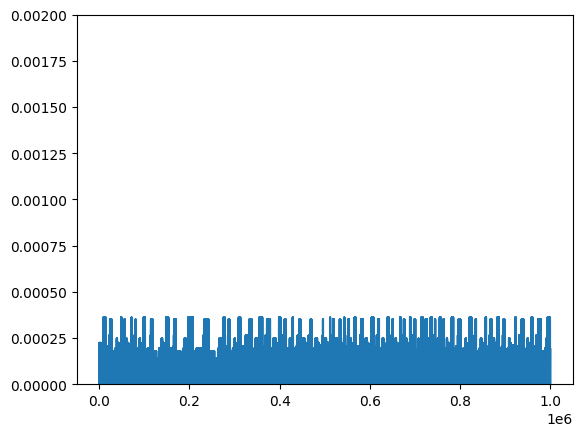

In [30]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
labels_chr_1 = pl.read_parquet("/mnt/fast/epigenomics/conschti/labels/512_64/1.parquet").drop("sequence")
i = np.arange(labels_chr_1.height)
# labels_chr_1 = labels_chr_1.with_columns(i=i).set_sorted("i")
# averaged = labels_chr_1.group_by_dynamic(index_column="i", period="1000000i", every="500i").agg(pl.mean("alpha"), pl.mean("beta"), pl.mean("std_st"))
embeddings_chr_1 = pl.read_parquet("/mnt/fast/epigenomics/conschti/embeddings/chr_1.parquet")
data = embeddings_chr_1.hstack(labels_chr_1).with_columns(i=i).set_sorted("i")
windowed = data.filter(pl.col("sequence") == 2)[:10000].group_by_dynamic(index_column="i", period="64i", every="32i").agg(pl.sum("h2az"), pl.mean("alpha"), pl.mean("beta"), pl.mean("std_st"))

beginning = data[:1000000].sort(by="Chromatine States")
display(beginning)
plt.plot( beginning["alpha"])



# plt.plot(windowed["i"], windowed["alpha"])
# plt.plot(windowed["i"], windowed["beta"])
# plt.plot(windowed["i"], windowed["std_st"])
# plt.plot(averaged["i"], averaged["alpha"])
# plt.plot(averaged["i"], averaged["beta"])
# plt.plot(averaged["i"], averaged["std_st"])
# plt.legend(["Alpha", "Beta"])
# plt.show()
# labels_chr_1 = labels_chr_1.filter(pl.col("sequence") == 2)
# plt.scatter(labels_chr_1[:10000000]["i"], labels_chr_1[:10000000]["alpha"])
# # plt.plot(labels_chr_1[:100000]["i"], labels_chr_1[:100000]["beta"], color=r)
plt.ylim(0, 0.002)


In [31]:
X = data.drop("i").filter((pl.col("sequence") == 2) & (pl.col("alpha") > 0))
y = X["alpha"]
X = X.drop("alpha").drop("beta").drop("std_st")

reg = LinearRegression().fit(X, y).score(X, y)
print(reg)

0.0011497389339802933


In [36]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
X = agg_data.drop("i").filter((pl.col("alpha") > 0))
y = X["alpha"]
X = X.drop("alpha").drop("beta").drop("std_st").drop("slice").drop("Chromatine States").drop("sequence").drop("genes").drop("start").drop("end")
X = X - X.mean_horizontal()
display(X)

clf = tree.DecisionTreeRegressor()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05 , random_state=42)
# gnb = GaussianNB()
# score = gnb.fit(X_train, y_train).score(X_test, y_test)
# print(score)
reg = LinearRegression().fit(X_train, y_train).score(X_train, y_train)
print(reg)
score = clf.fit(X_train, y_train).score(X_test, y_test)
print(score)

h2az,H3,H3K27Me3,H3K36Me3,H3K4Me1,H3K4Me3,H3K56Ac,chrsm
i64,i64,i64,i64,i64,i64,i64,i64
1248718,1252514,1145402,1203266,1243083,1200199,1239614,1
1251666,1255071,1149172,1208092,1246329,1204105,1242150,1
1265526,1269127,1163242,1223041,1260510,1219202,1255448,1
1273063,1276544,1172686,1232649,1269076,1229011,1262596,1
1268974,1272142,1171912,1228049,1264665,1223851,1258650,1
1286493,1289734,1187089,1245116,1282658,1240966,1276228,1
1287229,1290672,1190283,1245318,1283370,1240581,1278015,1
1301694,1305058,1205249,1263658,1297865,1257357,1293049,1
1315422,1318725,1219604,1277198,1311881,1269791,1306974,1


0.0030156777357661646
-3.046440506575477


In [ ]:
from statsmodels.formula.api import ols

d = agg_data.drop(["sequence", "slice"]).filter((pl.col("alpha") > 0))
# rename Chromatine States to Chromatine_States
d = d.rename({"Chromatine States": "Chromatine_States"})
display(d)


alpha_formula = "alpha ~ " + " + ".join([s for s in d.columns if s != "alpha" and s != "beta" and s != "std_st"])
beta_formula = "beta ~ " + " + ".join([s for s in d.columns if s != "alpha" and s != "beta" and s != "std_st"])
std_st_formula = "std_st ~ alpha + beta"
print(alpha_formula)
alpha_intragenic_model = ols(alpha_formula, d).fit()
# beta_intragenic_model = ols(beta_formula, data).fit()
# std_st_intragenic_model = ols(std_st_formula, data).fit()

print(alpha_intragenic_model.summary())
# print(beta_intragenic_model.summary())
# print(std_st_intragenic_model.summary())

print(alpha_intragenic_model.rsquared_adj)
# print(beta_intragenic_model.rsquared_adj)
# print(std_st_intragenic_model.rsquared_adj)

genes,Chromatine_States,h2az,H3,H3K27Me3,H3K36Me3,H3K4Me1,H3K4Me3,H3K56Ac,chrsm,start,end,alpha,beta,std_st
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64
-6195,237388,13709,13713,12693,13093,13496,12910,13410,1,109,13847,0.000504,0.000086,0.854391
-6195,190538,12784,12784,11860,12315,12643,12080,12561,1,2807,15591,0.0014,0.003288,0.298626
-6195,220624,13308,13419,12596,12523,13389,12554,13132,1,3807,17833,0.000275,0.001,0.215726
-6195,247310,13488,13682,12882,12665,13560,12513,13131,1,5151,19985,0.000093,0.001668,0.052911
-6195,266088,12894,13088,12225,11722,12785,11613,12377,1,6817,21057,0.000192,0.006046,0.03071
-6195,247714,11260,11454,10929,9969,11073,9768,10831,1,9334,21940,0.000143,0.000915,0.135409
-5158,235440,9859,10053,9291,8642,9672,8459,9511,1,11976,23181,0.000302,0.00005,0.857849
-1926,241016,10347,10541,9739,9130,10160,8947,9999,1,12662,24355,7.9403e-9,0.000004,0.002195
2588,219076,10297,10530,9685,9190,10153,8924,9988,1,14028,25710,0.000201,0.016821,0.011788


alpha ~ genes + Chromatine_States + h2az + H3 + H3K27Me3 + H3K36Me3 + H3K4Me1 + H3K4Me3 + H3K56Ac + chrsm + start + end
                            OLS Regression Results                            
Dep. Variable:                  alpha   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8848
Date:                Sun, 07 Jan 2024   Prob (F-statistic):              0.562
Time:                        18:08:04   Log-Likelihood:             1.9053e+05
No. Observations:               74353   AIC:                        -3.810e+05
Df Residuals:                   74340   BIC:                        -3.809e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
----

In [ ]:
from statsmodels.formula.api import ols

d = data.drop("i").filter(pl.col("sequence") == 2 & (pl.col("alpha") > 0))
# rename Chromatine States to Chromatine_States
d = d.rename({"Chromatine States": "Chromatine_States"})


alpha_formula = "alpha ~ " + " + ".join([s for s in d.columns if s != "alpha" and s != "beta" and s != "std_st"])
beta_formula = "beta ~ " + " + ".join([s for s in d.columns if s != "alpha" and s != "beta" and s != "std_st"])
std_st_formula = "std_st ~ alpha + beta"
print(alpha_formula)
# alpha_intragenic_model = ols(alpha_formula, d).fit()
# beta_intragenic_model = ols(beta_formula, data).fit()
std_st_intragenic_model = ols(std_st_formula, data).fit()

# print(alpha_intragenic_model.summary())
# print(beta_intragenic_model.summary())
print(std_st_intragenic_model.summary())

# print(alpha_intragenic_model.rsquared_adj)
# print(beta_intragenic_model.rsquared_adj)
print(std_st_intragenic_model.rsquared_adj)

alpha ~ sequence + genes + Chromatine_States + h2az + H3 + H3K27Me3 + H3K36Me3 + H3K4Me1 + H3K4Me3 + H3K56Ac


KeyboardInterrupt: 